# Fine-tune the SentenceBERT
In this experiment, we gonna learn about SBERT and going to see a practical demonstration of finetuning a SBERT on a custom dataset.

## SBERT
- It is based on Siamese Neural Network.

**Intuition**  
- A siamese network is a class of neural network that contains two identical networks(the same configurations, same parameters and weights).
- Parameter updating is mirrored across both networks.
- Siamese nn find similarity of inputs by comparing its feature vectors.

Let's understand the high-level overview of SBERT architecture.

![Screenshot from 16-02-24 22:01:29](https://github.com/surajkarki66/shortIT/assets/50628520/f62a89c5-220c-4c63-bbd7-2486f60d35e8)

- Sentence BERT uses pre-trained BERT networks and only fine tune it to yield useful sentence embeddings.
- To fine-tune our model, we create Siamese networks (bi-encoder) to update the weights such that the produced sentence embeddings are semantically meaningful.

## Implementation
- Inspired from [here](https://www.pinecone.io/learn/series/nlp/train-sentence-transformers-softmax/)

**NLI Training**  
- There are several ways of training sentence transformers. One of the most popular (and the approach we will cover) is using Natural Language Inference (NLI) datasets.

- NLI focus on identifying sentence pairs that infer or do not infer one another. We will use two of these datasets; the Stanford Natural Language Inference (SNLI) and Multi-Genre NLI (MNLI) corpora.

- 943K sentence pairs are obtained by combining these two corpora (550K from SNLI and 393K from MNLI). Every pair has a premise and a hypothesis, and a label is given to each pair:
  - 0 — entailment => e.g. the premise suggests the hypothesis.
  - 1 — neutral => the premise and hypothesis could both be true, but they are not necessarily related.
  - 2 — contradiction => the premise and hypothesis contradict each other.

- When training the model, we will be feeding sentence A (the premise) into BERT, followed by sentence B (the hypothesis) on the next step.

## Load the dataset
For now, let’s download the snli datasets. We will use the datasets library from Hugging Face.

In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.6/536.6 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 40.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.7 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 10.0.1
    Uninstalling pyarrow-10.0.1:
      Successfully uninstalled pyarrow-10.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ibis-framework 7.1.0 requires pyarrow<15,>=2, but you have pyarrow 15.0.0 which is incompatible.


In [2]:
import datasets

snli = datasets.load_dataset('snli', split='train')
print(snli)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Downloading:   0%|          | 0.00/1.93k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.26M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/65.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.26M [00:00<?, ?B/s]

Dataset({
    features: ['premise', 'hypothesis', 'label'],
    num_rows: 550152
})


In [3]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA (GPU) is available")
else:
    device = torch.device("cpu")
    print("CUDA (GPU) is not available, falling back to CPU")

CUDA (GPU) is available


In [4]:
snli[0]

{'premise': 'A person on a horse jumps over a broken down airplane.',
 'hypothesis': 'A person is training his horse for a competition.',
 'label': 1}

In [5]:
print(snli)

Dataset({
    features: ['premise', 'hypothesis', 'label'],
    num_rows: 550152
})


Both datasets contain -1 values in the label feature where no confident class could be assigned. We remove them using the filter method.

In [6]:
# there are -1 values in the label feature, these are where no class could be decided so we remove
dataset = snli.filter(
    lambda x: 0 if x['label'] == -1 else 1
)
print(len(dataset))

Filter:   0%|          | 0/550152 [00:00<?, ? examples/s]

549367


This means that we need to tokenize our sentences in order to translate them from human-readable text into transformer-readable code. The input_ids and attention_mask tensors for the premise and hypothesis features need to be divided separately.

In [4]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [8]:
all_cols = ['label']

In [9]:
for part in ['premise', 'hypothesis']:
    dataset = dataset.map(
        lambda x: tokenizer(
            x[part], max_length=128, padding='max_length',
            truncation=True
        ), batched=True
    )
    for col in ['input_ids', 'attention_mask']:
        dataset = dataset.rename_column(
            col, part+'_'+col
        )
        all_cols.append(part+'_'+col)
print(all_cols)

Map:   0%|          | 0/549367 [00:00<?, ? examples/s]

Map:   0%|          | 0/549367 [00:00<?, ? examples/s]

['label', 'premise_input_ids', 'premise_attention_mask', 'hypothesis_input_ids', 'hypothesis_attention_mask']


Since, it will take forever to train a model on full dataset even for a single epoch. Only for demonstration i am gonna use small part of dataset

In [10]:
subset_dataset = dataset.select(range(25000))

All that's left to do is get the data ready for the model to read. In order to accomplish this, we first translate the features in the dataset into PyTorch tensors and then build up a data loader to provide data to our model while it is being trained.

In [11]:
import torch

# covert dataset features to PyTorch tensors
subset_dataset.set_format(type='torch', columns=all_cols)


# initialize the dataloader
batch_size = 16
train_loader = torch.utils.data.DataLoader(
    subset_dataset, batch_size=batch_size, shuffle=True
)

## Model Building
When we train an SBERT model, we don’t need to start from scratch. We begin with an already pretrained BERT model (and tokenizer).

In [6]:
from transformers import BertModel

# start from a pretrained bert-base-uncased model
model = BertModel.from_pretrained('bert-base-uncased')

During training, we'll be utilizing a "siamese"-BERT architecture. This simply implies that, given a pair of sentences, we feed sentence A into BERT first, and then, once BERT has completed processing the first, we input sentence B. It can be imagined that two identical BERTs are being trained in parallel on sentence pairs as a result, resulting in a network that resembles a siamese. The truth is that only one model processes the two sentences consecutively.

![image](https://cdn.sanity.io/images/vr8gru94/production/2425dc0efd3f73a0bf57b3bf85a091c78619ec2c-1920x1110.png)

The results of BERT will be 512 768-dimensional embeddings. We will use mean-pooling to transform these into an average embedding. We call this combined output the sentence embedding. We'll have two each step: one we'll call u for sentence A and one called v for sentence B.

To perform this mean pooling operation, we will define a function called mean_pool

In [8]:
# define mean pooling function
def mean_pool(token_embeds, attention_mask):
    # reshape attention_mask to cover 768-dimension embeddings
    in_mask = attention_mask.unsqueeze(-1).expand(
        token_embeds.size()
    ).float()

    # perform mean-pooling but exclude padding tokens (specified by in_mask)
    pool = torch.sum(token_embeds * in_mask, 1) / torch.clamp(
        in_mask.sum(1), min=1e-9
    )
    return pool

Here we take BERT’s token embeddings output (we’ll see this all in full soon) and the sentence’s attention_mask tensor. We then resize the attention_mask to align to the higher 768-dimensionality of the token embeddings.

We apply this resized mask in_mask to those token embeddings to exclude padding tokens from the mean pooling operation. Our mean pooling takes the average activation of values across each dimension to produce a single value. This brings our tensor sizes from (512*768) to (1*768).

The next step is to concatenate these embeddings. Several different approaches to this were presented in the paper:

![image](https://cdn.sanity.io/images/vr8gru94/production/00d55e9a758896248c3332c4a475c02c17fc1bb9-998x996.png)

The most effective of these is created by joining vectors u, v, and |u-v|. A vector that is three times longer than each original vector is created when they are all concatenated. This concatenated vector (u, v, |u-v|) is labeled by us. where the element-wise difference between vectors u and v is denoted by |u-v|.

In [14]:
# we would initialize the feed-forward NN first
ffnn = torch.nn.Linear(768*3, 3)
ffnn = ffnn.to(device)

## Loss function
- In the original SBERT work, Reimers and Gurevych's main strategy was optimizing with softmax loss.
- Even though the initial sentence transformer model was trained using this, it is no longer the recommended training method.


In [15]:
# as before, we would initialize the loss function first
loss_func = torch.nn.CrossEntropyLoss()

In [16]:
from transformers.optimization import get_linear_schedule_with_warmup


# we would initialize everything first
optim = torch.optim.Adam(model.parameters(), lr=2e-5)

# and setup a warmup for the first ~10% steps
total_steps = int(len(subset_dataset) / batch_size)
warmup_steps = int(0.1 * total_steps)
scheduler = get_linear_schedule_with_warmup(
		optim, num_warmup_steps=warmup_steps,
  	num_training_steps=total_steps - warmup_steps
)

## Train the model


In [17]:
EPOCHS = 1

In [18]:
model = model.to(device)

In [19]:
from tqdm.auto import tqdm

# 1 epoch should be enough for our demo
for epoch in range(EPOCHS):
    model.train()  # make sure model is in training mode
    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        # zero all gradients on each new step
        optim.zero_grad()

        # prepare batches and more all to the active device
        inputs_ids_a = batch['premise_input_ids'].to(device)
        inputs_ids_b = batch['hypothesis_input_ids'].to(device)
        attention_a = batch['premise_attention_mask'].to(device)
        attention_b = batch['hypothesis_attention_mask'].to(device)
        label = batch['label'].to(device)

        # extract token embeddings from BERT
        u = model(inputs_ids_a, attention_mask=attention_a)[0]  # all token embeddings A
        v = model(inputs_ids_b, attention_mask=attention_b)[0]  # all token embeddings B

        # get the mean pooled vectors
        u = mean_pool(u, attention_a)
        v = mean_pool(v, attention_b)

        # build the |u-v| tensor
        uv = torch.sub(u, v)
        uv_abs = torch.abs(uv)

        # concatenate u, v, |u-v|
        x = torch.cat([u, v, uv_abs], dim=-1)

        # process concatenated tensor through FFNN
        x = ffnn(x)

        # calculate the 'softmax-loss' between predicted and true label
        loss = loss_func(x, label)

        # using loss, calculate gradients and then optimize
        loss.backward()
        optim.step()

        # update learning rate scheduler
        scheduler.step()

        # update the TDQM progress bar
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())

  0%|          | 0/1563 [00:00<?, ?it/s]

Here, we train for just one period. This should be sufficient in practice, as it is consistent with the original SBERT paper's description. Saving the model is the last thing that has to be done.

In [20]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [21]:
import os

model_path = '/content/drive/MyDrive/Colab Notebooks/sbert_soft_scratch'

if not os.path.exists(model_path):
    os.mkdir(model_path)

model.save_pretrained(model_path)

## Fine tuning using sentence transformer library
As we already mentioned, the sentence-transformers library has excellent support for those of us just wanting to train a model without worrying about the underlying training mechanisms.

For this approach, we have to change the way the data will be input to the model.

In [30]:
# download
snli = datasets.load_dataset('snli', split='train')

In [31]:
# and remove bad rows
snli = snli.filter(
    lambda x: False if x['label'] == -1 else True
)

Now we’re ready to format our data for sentence-transformers. All we do is convert the current premise, hypothesis, and label format into an almost matching format with the InputExample class.

In [24]:
!pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.8/132.8 kB 3.8 MB/s eta 0:00:00


In [53]:
subset_snli = snli.select(range(25000))

In [58]:
from sentence_transformers import InputExample, losses
from tqdm.auto import tqdm

train_samples = []
for row in tqdm(subset_snli):
    train_samples.append(InputExample(
        texts=[row['premise'], row['hypothesis']],
        label=row['label']
    ))

  0%|          | 0/25000 [00:00<?, ?it/s]

setup loader

In [55]:
from torch.utils.data import DataLoader

batch_size = 16

loader = DataLoader(
    train_samples, shuffle=True, batch_size=batch_size)

## Model Building

In [49]:
from sentence_transformers import models, SentenceTransformer

bert = models.Transformer('bert-base-uncased')
pooler = models.Pooling(
    bert.get_word_embedding_dimension(),
    pooling_mode_mean_tokens=True # mean pooling
)

model = SentenceTransformer(modules=[bert, pooler])

print(model)

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False})
)


In [61]:
loss = losses.SoftmaxLoss(model, sentence_embedding_dimension=bert.get_word_embedding_dimension(), num_labels=3)
print(loss)

SoftmaxLoss(
  (model): SentenceTransformer(
    (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: BertModel 
    (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False})
  )
  (classifier): Linear(in_features=2304, out_features=3, bias=True)
  (loss_fct): CrossEntropyLoss()
)


Now we’re ready to train the model. We train for a single epoch and warm up for 10% of training as before.

In [62]:
epochs = 1
warmup_steps = int(len(loader) * epochs * 0.1)

model.fit(
    train_objectives=[(loader, loss)],
    epochs=epochs,
    warmup_steps=warmup_steps,
    output_path='/content/drive/MyDrive/Colab Notebooks/sbert_soft_lib',
    show_progress_bar=True,
)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1563 [00:00<?, ?it/s]

## Compare SBERT Models
We’re going to test the models on a set of random sentences.

In [1]:
sentences = [
    "The dog chased the ball in the park.",
    "She gazed at the stars twinkling in the night sky",
    "A playful puppy eagerly pursued the tennis ball through the grassy field.",
    "The aroma of freshly baked bread filled the kitchen",
    "Warm bread, straight from the oven, perfumed the air with its enticing scent."
]

After producing sentence embeddings, we will calculate the cosine similarity between all possible sentence pairs, producing a simple but insightful semantic textual similarity (STS) test.

We define two new functions; sts_process to build the sentence embeddings and compare them with cosine similarity and sim_matrix to construct a similarity matrix from all possible pairs.

In [10]:
import numpy as np
import torch

from torch.nn.functional import cosine_similarity

# controller function to build similarity matrix
def sim_matrix(model):
    # initialize empty zeros array to store similarity scores
    sim = np.zeros((len(sentences), len(sentences)))
    for i in range(len(sentences)):
        # add similarity scores to the similarity matrix
        sim[i:,i] = sts_process(sentences[i], sentences[i:], model)
    return sim

# build embeddings and calculate cosine similarity
def sts_process(sentence_a, sentence_b, model):
    vecs = []  # init list of sentence vecs
    for sentence in [sentence_a, sentence_b]:
        # build input_ids and attention_mask tensors with tokenizer
        input_ids = tokenizer(
            sentence, max_length=512, padding='max_length',
            truncation=True, return_tensors='pt'
        )
        # process tokens through model and extract token embeddings
        token_embeds = model(**input_ids).last_hidden_state
        # mean-pool token embeddings to create sentence embeddings
        sentence_embeds = mean_pool(token_embeds, input_ids['attention_mask'])
        vecs.append(sentence_embeds)

    # calculate cosine similarity between pairs and return numpy array
    return cosine_similarity(vecs[0], vecs[1]).detach().numpy()


<Axes: >

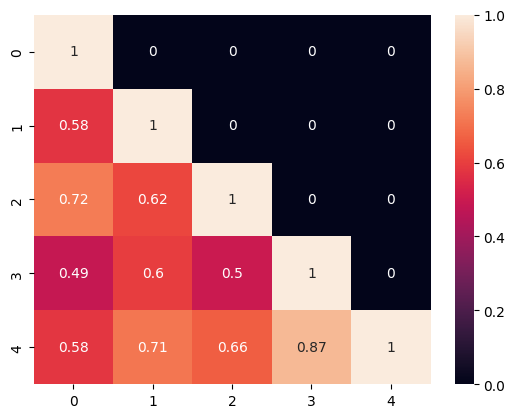

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model_a = BertModel.from_pretrained('/content/drive/MyDrive/Colab Notebooks/sbert_soft_scratch')

sim = sim_matrix(model_a)  # build similarity scores matrix
sns.heatmap(sim, annot=True)  # visualize heatmap

<Axes: >

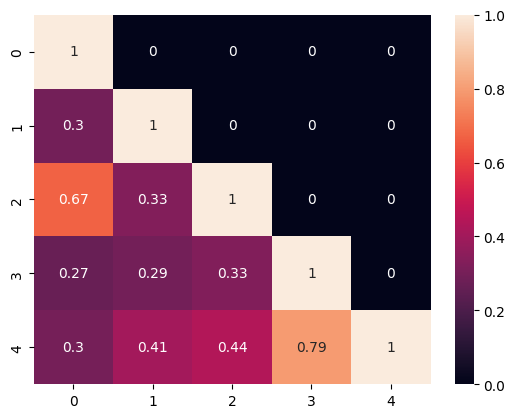

In [12]:
model_b = BertModel.from_pretrained('/content/drive/MyDrive/Colab Notebooks/sbert_soft_lib')

sim = sim_matrix(model_b)  # build similarity scores matrix
sns.heatmap(sim, annot=True)  # visualize heatmap

## Conclusion
As we can see, we have trained the same model using two different way and also compare their performances on bunch of sentences. Consequently, we observed that the model performance is not that good, because of the following two reasons:
- Softmax Loss
- Training only single epoch